# BBC News Classification

**DTSA 5510 Unsupervised Algorithms in Machine Learning**


**University of Colorado Boulder**

This notebook explores the classification of BBC news articles into five categories using both unsupervised and supervised machine learning approaches. The unsupervised method uses Truncated SVD for topic modeling and cosine similarity for prediction. To compare this method with a supervised approach, I’ve implemented a Random Forest Classifier. The project includes exploratory data analysis, hyperparameter tuning, model evaluation, and my final submission to the Kaggle competition.

## Import Modules

This section imports necessary Python libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), natural language processing (nltk), and machine learning (sklearn). Warnings are suppressed to avoid clutter from known issues like the token_pattern warning from TfidfVectorizer and a pandas formatting issue. I rely on these modules for data loading, text preprocessing, model training, and performance evaluation throughout this notebook.

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sci-kit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# regex
import re

# warnings
import warnings

In [2]:
warnings.filterwarnings('ignore', message="The parameter 'token_pattern' will not be used")
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

## Load Data

This section downloads the NLTK stopwords dataset, which consists of low-information words that will be disregarded in the model, and loads the BBC News Train and Test CSV files from Kaggle. The training data includes news articles, their categories, and their article IDs, while the test data excludes the categories, which is the target for this dataset.

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
train_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

# Unsupervised Approach - Truncated SVD

## Exploratory Data Analysis

In this section, I analyze the BBC News dataset to understand its characteristics and determine the completeness of the set. Initial checks of the dataset show 1490 training and 735 testing samples, no missing values, and no duplicates. The articles fall under 5 different categories with varying numbers of articles in each: business (336), entertainment (273), politics (274), sports (346), and tech (261). Each category has between 200 and 350 articles. Of the categories, tech has the most words (130985), and entertainment has the least (91158). The richest vocabulary (0.133066) with the most unique words, as seen in the visualization below, belongs to entertainment despite this category having fewer words overall. The politics category has the least rich vocabulary (0.093292) although it ranks second in number of words (123215). In order to represent this data visually, I plot a dual-axis plot displaying a bar chart with total number of words and vocabulary richness over each category.


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB

Train Data Shape: (1490, 3)

Test Data Shape: (735, 2)

Training Data Head:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  busine

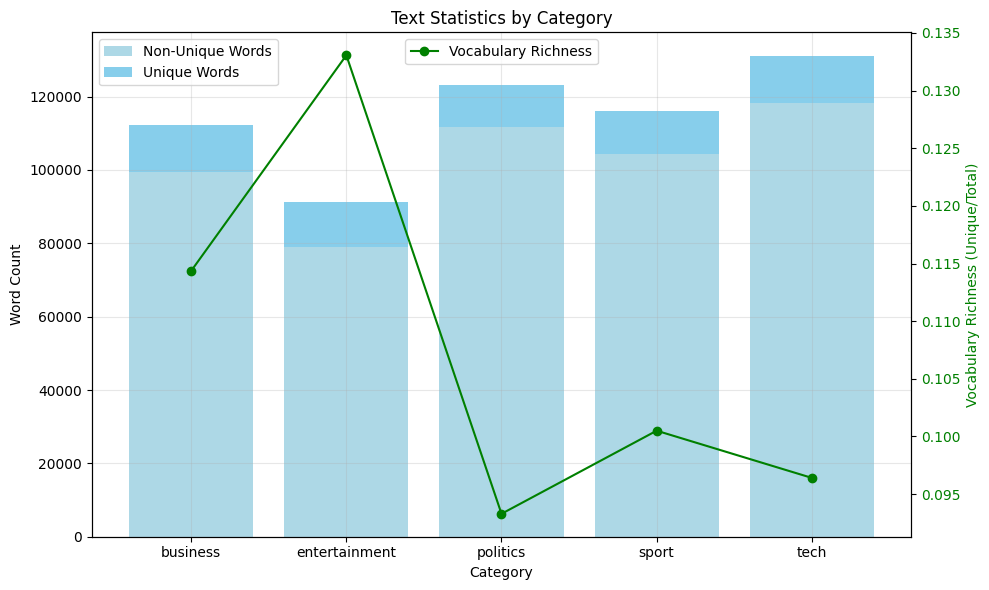

In [5]:
print('\nTraining Data Info:')
train_data.info()

print('\nTesting Data Info:')
test_data.info()

print('\nTrain Data Shape:', train_data.shape)
print('\nTest Data Shape:', test_data.shape)

print('\nTraining Data Head:')
print(train_data.head())

print("\nMissing values in Training Set:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Set:")
print(test_data.isnull().sum())

print("\nDuplicated values in Training Set:")
print(train_data.duplicated().sum())
print("\nDuplicated Values in Test Set:")
print(test_data.duplicated().sum())

print("\nCategory Counts in Train Set:")
category_counts = train_data['Category'].value_counts()
print(category_counts)

texts_by_category = train_data.groupby('Category')['Text'].apply(list)
category_stats = {}
for category, texts in texts_by_category.items():
    combined_text = ' '.join(texts)
    all_words = combined_text.lower().split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    category_stats[category] = {
        'total_words': total_words,
        'unique_words': unique_words,
        'vocabulary_richness': unique_words / total_words
    }

stats_df = pd.DataFrame.from_dict(category_stats, orient='index')
print("\nText Statistics by Category:")
print(stats_df)

fig, ax1 = plt.subplots(figsize=(10, 6))
stats_df['non_unique_words'] = stats_df['total_words'] - stats_df['unique_words']
ax1.bar(stats_df.index, stats_df['non_unique_words'], label='Non-Unique Words', color='lightblue')
ax1.bar(stats_df.index, stats_df['unique_words'], bottom=stats_df['non_unique_words'], label='Unique Words', color='skyblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Word Count')
ax1.set_title('Text Statistics by Category')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(stats_df.index, stats_df['vocabulary_richness'], color='green', marker='o', label='Vocabulary Richness')
ax2.set_ylabel('Vocabulary Richness (Unique/Total)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper center')
plt.tight_layout()
plt.show()

Based on the exploratory data analysis above, my plan to classify articles includes the multiple steps completed hereafter. The plan includes preprocessing the data to reduce variation via stemming, tokenizing, and standardizing; implementing TF-IDF vectorization to convert text to numerical features; and applying Truncated SVD to model the topics of each article and classify them based on their cosine similarity to eachother. Each of these steps will be discussed further in their respective sections within this notebook.

## Data Preprocessing

The first step is preprocessing, during which I apply stemming using the Natural Language Tookkit's Snowball Stemmer to reduce the word variation in each article. This is important because the variation in vocabulary between categories is unbalanced with entertainment having a wider variety of words than the rest of the categories by a wide margin. The Snowball Stemmer is a popular algorithm used in Natural Language Processing that reduces words to their stems (or roots in some cases). For example, the words "running", "runs", and "ran" would be considered three unique words before stemming. After stemming, they are reduced to "run", "run", and "ran", greatly reducing the number of unique words and overall variation. Another strategy employed to reduce the complexity of the data is removing stop words, which are low-information words listed in Natural Language Toolkit's stopwords list downloaded earlier. As you can imagine, typical writing involves the frequent use of words like "the", "and", and "is". While these stopwords are important for sentence structure, they do not offer much to our overall understanding of semantics, so they are ignored. In addition to the previous methods, the words are also passed through a custom tokenizer to standardize letters in their lowercase, remove punctuation, remove digits, and remove special symbols.

In [6]:
def process_stop_words(stopwords_list):
    
    stop_words_set = set()
    for word in stopwords_list:
        
        processed_word = word.lower()
        processed_word = re.sub(r'[^\w\s]', '', processed_word)
        processed_word = re.sub(r'\d+', '', processed_word)
        
        if processed_word:
            
            stemmed_word = stemmer.stem(processed_word)
            stop_words_set.add(stemmed_word)
    
    return list(stop_words_set)

def custom_tokenizer(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stems = [stemmer.stem(word) for word in words]
    
    return stems

def predict_labels_training(similarity_matrix, labels, exclude_self=True):

    predictions = []
    for i, sim in enumerate(similarity_matrix):

        sim[i] = -float('inf')  # Exclude self-similarity
        most_similar_idx = np.argmax(sim)
        predictions.append(labels[most_similar_idx])
    
    return predictions

After preprocessing, I implement TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to transform text into weighted feature vectors by balancing each word's frequency with its uniqueness across articles. In this approach, how often a word appears in a document is multiplied by its inverse document frequency, emphasizing distinct words while penalizing words that show up often. The inverse document frequency acts as a penalty factor in this case. For instance, the word "election" might receive a higher TF-IDF weight in articles about politics than articles about any other topic, making it a distinguishing feature in politics articles and therefore valuable for classification. 

The previously described stemming and text standardization help reduce the complexity of the data since many of the words are ignored. Additionally, vocabulary size and document frequency thresholds are optimized later in this notebook to reduce the number of relevant terms further. Ultimately, the corpus of BBC articles is transformed into a sparse matrix that contains the TF-IDF weight for each term in each article.

In [7]:
stemmer = SnowballStemmer('english')
stop_words = process_stop_words(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

print(f"\nTF-IDF Matrix Shape (Train): {tfidf_matrix_train.shape}")
print(f"TF-IDF Matrix Shape (Test): {tfidf_matrix_test.shape}")
print(f"Number of Features: {len(tfidf_vectorizer.get_feature_names_out())}")


TF-IDF Matrix Shape (Train): (1490, 17699)
TF-IDF Matrix Shape (Test): (735, 17699)
Number of Features: 17699


Once the features are configured and the data is cleaned, I apply Truncated Singular Value Decomposition (SVD) to topic modeling and dimensionality reduction, optimizing for the best number of components to represent article topics. This an unsupervised machine learning technique that is particularly useful because the test data lacks the target feature. Because this approach is unsupervised, I use the cosine similarity between article vectors transformed via SVD to categorize similar articles and evaluate the results.

## Model Training & Hyperparameter Tuning

This section trains the Truncated SVD model and tunes hyperparameters to optimize performance. The process involves a grid-search-style hyperparameter selection. 

I'm using Truncated SVD for dimensionality reduction because it works well for text data and is a common technique in natural language processing. Truncated SVD decomposes the TF-IDF matrix into three components: U, Σ, and V.T, but keeps only the top k singular values and their corresponding vectors. The process works by taking our document-term matrix and decomposing it into a document-topic matrix, a diagonal matrix of singular values (representing topic strengths), and a term-topic matrix. Instead of working with thousands of word features, we end up with just a few latent topics (k components) that represent the key variations in the data. The algorithm naturally discovers patterns based on word co-occurrences, or how words tend to appear, across documents without requiring target labels. After transforming the training and test articles into a reduced semantic space, cosine similarity can be used to find which training article each test article compares to best, and assign the appropriate category.

When thinking about how to handle the test data in this unsupervised approach, I faced an important question: _should test data be included in unsupervised training?_ The answer is that best practices dictate that test data should **not** be included in training. Including test data during fitting would constitute data leakage since the model would learn patterns present in the test set. This violates the principle of evaluating models on unseen data. The correct approach is to fit the TF-IDF vectorizer on training data only, transform both training and test data using this fitted vectorizer, fit Truncated SVD on the training TF-IDF matrix only, then transform both training and test TF-IDF matrices using this fitted SVD. This ensures our evaluation reflects how the model will perform on unseen articles in the "real world."

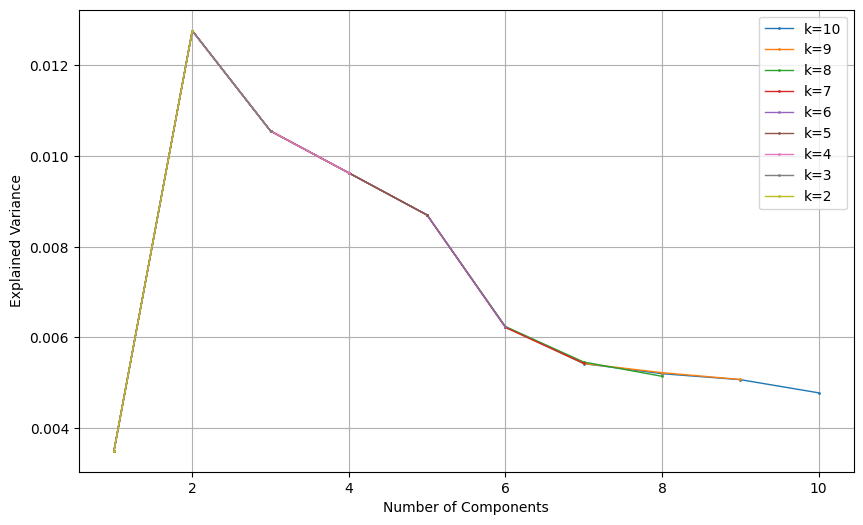

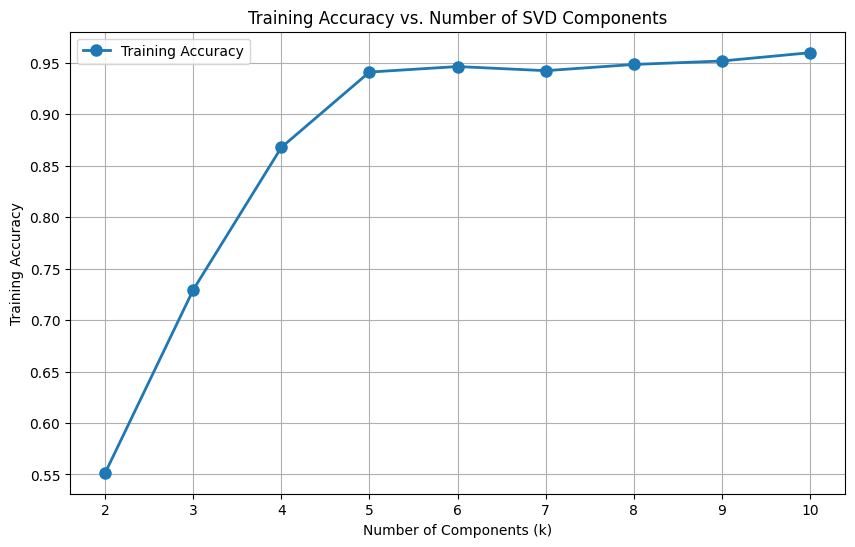

k | Training Accuracy
2  | 0.5517
3  | 0.7295
4  | 0.8678
5  | 0.9409
6  | 0.9463
7  | 0.9423
8  | 0.9483
9  | 0.9517
10 | 0.9597


In [8]:
train_labels = train_data['Category'].values
k_values = range(2, 11)
train_accuracies = []

plt.figure(figsize=(10,6))
for k in reversed(k_values):
    svd = TruncatedSVD(n_components=k, random_state=53)
    tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

    train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
    train_predictions = predict_labels_training(train_similarity, train_labels)
    
    train_acc = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_acc)

    cumulative_variance = svd.explained_variance_ratio_ 
    plt.plot(range(1, k + 1), cumulative_variance, 
             label=f'k={k}', marker='o', markersize=1, linewidth=1)

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), list(reversed(train_accuracies)), label='Training Accuracy', marker='o', markersize=8, linewidth=2)
plt.xlabel('Number of Components (k)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Number of SVD Components')
plt.grid(True)
plt.legend()
plt.show()

print("k | Training Accuracy")
for k, acc in zip(k_values, reversed(train_accuracies)):
    print(f"{k:<2} | {acc:.4f}")

For component selection (k), I test values from 2 to 10 and plot the explained variance and training accuracy. It is evident that k=5 provides the best accuracy (approximately 0.94) while capturing maximal variance. This confirms an initial hunch that the best number of components is equal to the number of categories that the articles can belong to. To tune the TF-IDF feature engineering, I implemented a grid search over max_features (1000, 5000, 10000, None) and max_df thresholds (0.5, 0.75, 0.9, 1.0), using the training accuracy of each combination to identify the optimal configuration, which turned out to include terms if their document frequency was 0.90 or less (max_df=0.9) and limit the vocabulary size (max_features=5000). There was a tie between 2 configurations, so I picked the one that uses less data overall.

In [9]:
train_labels = train_data['Category'].values
max_features_values = [1000, 5000, 10000, None]  
max_df_values = [0.5, 0.75, 0.9, 1.0] 
results = []

for f in max_features_values:
    
    for d in max_df_values:
        
        tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=d, max_features=f)
        tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])

        svd = TruncatedSVD(n_components=5, random_state=53)
        tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

        train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
        train_predictions = predict_labels_training(train_similarity, train_labels)
        
        train_acc = accuracy_score(train_labels, train_predictions)
        results.append({'max_features': f, 'max_df': d, 'train_accuracy': train_acc})

results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)


Hyperparameter Tuning Results:
    max_features  max_df  train_accuracy
0         1000.0    0.50        0.930201
1         1000.0    0.75        0.935570
2         1000.0    0.90        0.932215
3         1000.0    1.00        0.932215
4         5000.0    0.50        0.940940
5         5000.0    0.75        0.941611
6         5000.0    0.90        0.943624
7         5000.0    1.00        0.943624
8        10000.0    0.50        0.938255
9        10000.0    0.75        0.942953
10       10000.0    0.90        0.942282
11       10000.0    1.00        0.942282
12           NaN    0.50        0.938926
13           NaN    0.75        0.942953
14           NaN    0.90        0.940940
15           NaN    1.00        0.940940


The final model combines k=5, max_df=0.9, and max_features=5000.

In [10]:
best_hyperparams = results_df[results_df['train_accuracy'] == results_df['train_accuracy'].max()]
print(best_hyperparams)

   max_features  max_df  train_accuracy
6        5000.0     0.9        0.943624
7        5000.0     1.0        0.943624


Beyond basic hyperparameter tuning, I implemented several techniques (mentioned above in this section) to improve the model's performance. To recap, I used a custom tokenizer for both the stopwords and corpus with stemming to reduce word variants, lowercase conversion, punctuation removal, and used regex filtering to remove numbers and special characters. I also used cosine similarity with self-exclusion to prevent documents from being their own nearest neighbors, and used argmax for identifying the most similar article. Feature engineering refinements included experimenting with TF-IDF parameters. I visualized explained variance to understand information capture and generated confusion matrices to identify classification behavior.

## Final Model Build & Prediction

This final unsupervised model achieved a training accuracy of approximately 0.94. The confusion matrix indicates good classification across all categories since it is diagonally dominant. The model was then applied to the test set to generate predictions that were submitted to the Kaggle competition, yielding a test accuracy of 0.94557. This performance is strong, demonstrating that topic modeling with unsupervised approaches like Truncated SVD can effectively capture the semantic structure of news articles without requiring labeled training data.

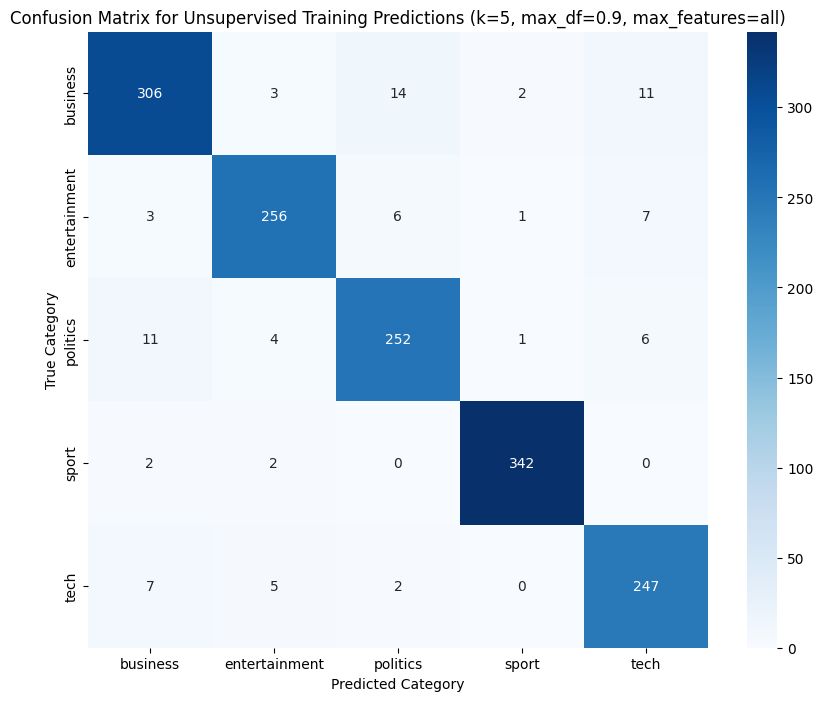


Unsupervised (k=5) Training Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.91      0.92       336
entertainment       0.95      0.94      0.94       273
     politics       0.92      0.92      0.92       274
        sport       0.99      0.99      0.99       346
         tech       0.91      0.95      0.93       261

     accuracy                           0.94      1490
    macro avg       0.94      0.94      0.94      1490
 weighted avg       0.94      0.94      0.94      1490



In [11]:
# final hyperparameters
k_final = 5
max_features_final = 5000
max_df_final = 0.9

train_labels = train_data['Category'].values

# preprocess data
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

# train and fit truncated SVD
svd = TruncatedSVD(n_components=k_final, random_state=None)
tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)
tfidf_SVD_test = svd.transform(tfidf_matrix_test)

# train
train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
train_predictions = predict_labels_training(train_similarity, train_labels, exclude_self=True)

# create training set confusion matrix
cm = confusion_matrix(train_labels, train_predictions)
plt.figure(figsize=(10, 8))
categories = np.unique(train_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title(f'Confusion Matrix for Unsupervised Training Predictions (k={k_final}, max_df={max_df_final}, max_features=all)')
plt.show()
print(f"\nUnsupervised (k={k_final}) Training Classification Report:")
print(classification_report(train_labels, train_predictions))

# predict on testing set and save for submission
test_similarity = cosine_similarity(tfidf_SVD_test, tfidf_SVD_train)
test_predictions = predict_labels_training(test_similarity, train_labels)
submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_predictions})
submission.to_csv('submission.csv', index=False)

# Supervised Approach - Random Forest Classifier

## Data Preprocessing

For the supervised approach, I make sure the preprocessing is consistent with the preprocessing for the unsupervised method. I use the same TfidfVectorizer settings (max_df=0.9, max_features=5000). This keeps the comparison between approaches fair with the only difference being the learning algorithm.

In [12]:
max_features_final = 5000
max_df_final = 0.9
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])

## Training Validation & Data Size Search

To understand data efficiency, I train the Random Forest Classifier on different sized subsets of the training data to show the patterns in model performance. With 10% of training data, the model achieved 1.0 training accuracy but only 0.88 validation accuracy. Upping the amount to 20% improved validation slightly to 0.91, while using 50% increased the validation accuracy to 0.94. In both of these cases, the training accuracy was 1.0 as well. These results show that the model consistently achieves high training accuracy regardless of data size. Additionally, validation performance improves with more training data to learn from. The performance with 50% of the data is comparable to the unsupervised method's training accuracy, indicating that the supervised approach can match unsupervised performance with sufficient labeled data.

In [13]:
train_labels = train_data['Category']
train_sizes = [0.1, 0.2, 0.5]
train_size_results = []

for size in train_sizes:
    
    X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=size, random_state=19)

    rf = RandomForestClassifier(random_state=53)
    rf.fit(X_train, y_train)
    train_preds = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    
    val_preds = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    
    train_size_results.append({'train_size': f"{int(size * 100)}%", 'train_accuracy': train_acc, 'val_accuracy': val_acc})
    #print(f"Train size: {int(size * 100)}%, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

train_size_results_df = pd.DataFrame(train_size_results)
print("\nRandomForest Data Size Tuning Results:")
print(train_size_results_df)


RandomForest Data Size Tuning Results:
  train_size  train_accuracy  val_accuracy
0        10%             1.0      0.862043
1        20%             1.0      0.916107
2        50%             1.0      0.947651


Using the best split (50%), the confusion matrix on the validation set shows that the model is making mistakes and misclassifying articles. Particularly, this is most frequent between related categories. While the model achieved 0.94 validation accuracy, there was some confusion between business and the other topics.

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Validation (Holdout) Predictions')

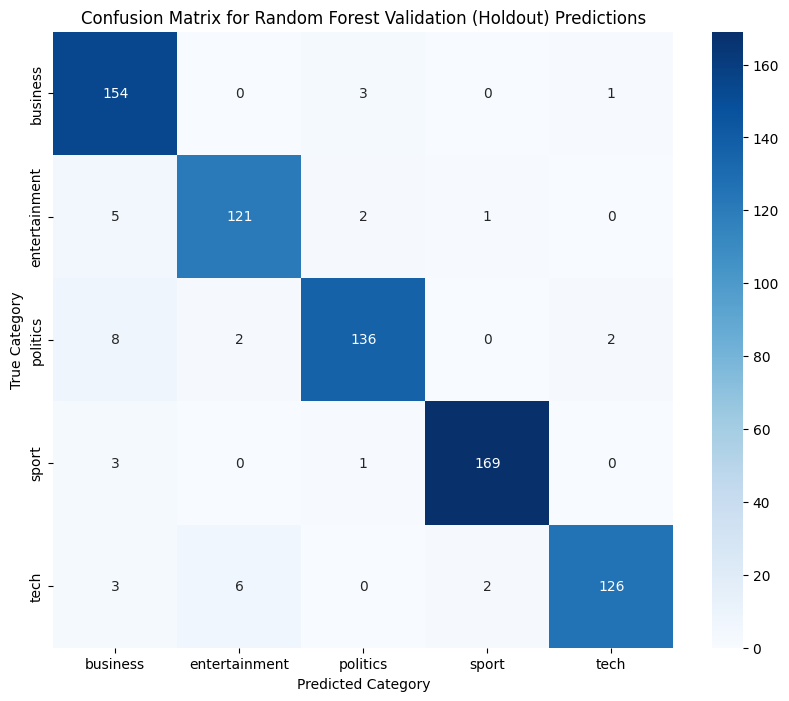

In [14]:
X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=0.5, random_state=19)

rf = RandomForestClassifier(random_state=53)
rf.fit(X_train, y_train)


train_preds = rf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

val_preds = rf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)

cm_val = confusion_matrix(y_val, val_preds)
categories = np.unique(train_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for Random Forest Validation (Holdout) Predictions')

## Predict on Testing Set

The final Random Forest Classifier is trained on the complete training dataset and applied to the test set for the Kaggle submission. This allows direct comparison with the unsupervised approach. The Kaggle test accuracy for the supervised approach was 0.96462, surpassing the score of 0.94557 from the unsupervised approach.

In [15]:
train_labels = train_data['Category']

# random forest
rf = RandomForestClassifier(random_state=53)

# train
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])
rf.fit(rf_tfidf_matrix_train, train_labels)

# predict
rf_tfidf_matrix_test = rf_tfidf_vectorizer.transform(test_data['Text'])
test_preds = rf.predict(rf_tfidf_matrix_test)


submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())

   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


# Discussion

Comparing the unsupervised Truncated SVD and supervised Random Forest approaches reveals their relative strengths. Performance-wise, the unsupervised approach achieved 0.94 training accuracy and 0.94557 Kaggle test accuracy, while the supervised Random Forest reached 1.0 training accuracy, 0.94 training validation accuracy, and 0.96462 Kaggle test accuracy when trained on the full dataset. This difference of approximately two percentage points on the test set stems from the advantage that labeled data provides to the supervised approach. The supervised method is able to use the labels to draw robust decision boundaries, whereas the unsupervised method is a bit more abstract since it relies on latent patterns in semantics.

The supervised Random Forest Classifier's perfect training accuracy suggests some overfitting as it is memorizing the patterns exactly, though it still generalized well to unseen data. The supervised model's superior test performance demonstrates that while unsupervised methods can perform strongly in the absence of labels, supervised approaches, at least in this case, leverage labels to achieve higher accuracy. Despite the score gap, the high accuracy of the unsupervised approach without using any category labels is impressive. This suggests that the latent topics recognized through Truncated SVD align with the news categories and indicate a natural separation between the categories in the feature space.

The data efficiency experiments performed in the supervised approach section show that the supervised approach can achieve similar holdout validation accuracy to the unsupervised method with only 50% of the training data, meaning that the supervised method is likely more data efficient and competitive with the unsupervised method. 

Future work could explore why the unsupervised method plateaus around 0.94. I think it is potentially due to limitations in the dataset, preprocessing, or natural differences between news categories. I noticed that the models misclassify politics and business frequently, so it could be worthwhile to dig into the differences between those categories. Additionally, a more robust data-efficiency metric would be interesting to develop so that the methods can be compared more fairly.

# Conclusion

This project demonstrated the effectiveness of both unsupervised and supervised learning approaches for BBC news classification. The unsupervised approach using Truncated SVD matrix factorization and cosine similarity achieved 0.94557 test accuracy, successfully capturing the latent topical structure of the corpus without using any category labels. The supervised Random Forest Classifier achieved a higher 0.96462 test accuracy and showed the advantages of labeled data.

In the context of the problem, it was found that Truncated SVD with k=5 components (matching the number of categories) effectively captured article semantics, the supervised approach demonstrated superior performance with full data, and text preprocessing and feature engineering significantly impacted both models. 

These results demonstrate the capabilities of both supervised and unsupervised learning for text classification tasks, with the choice between them depending on the availability of labeled data and the specific requirements of the application.

In [16]:
#!rm -rf /kaggle/working/*